In [170]:
!pip install category_encoders
!pip install catboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
RocCurveDisplay
from datetime import timedelta

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
sns.set(style="dark")

# READ DATA

In [171]:
df_year = pd.read_csv("/content/Year 2010-2011.csv", encoding='latin1')
df_year.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


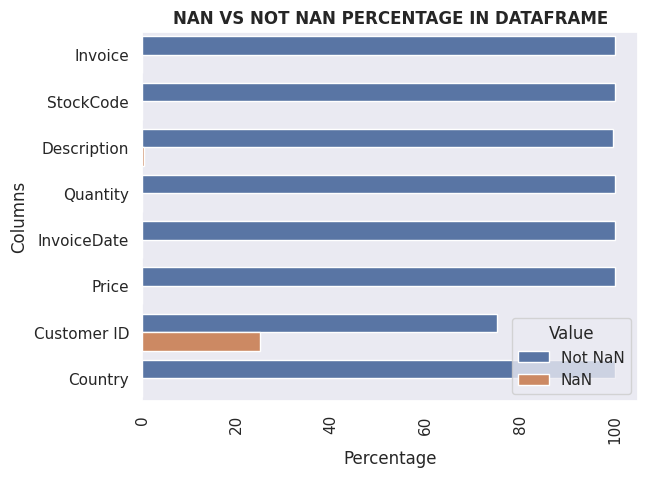

In [172]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the percentage of NaN and non-NaN in each column
total_counts = len(df_year)
nan_percentages = (df_year.isna().sum() / total_counts) * 100
not_nan_percentages = (df_year.notna().sum() / total_counts) * 100

# Create DataFrame from calculated data
percentages_df = pd.DataFrame({'Columns': nan_percentages.index, 'Not NaN': not_nan_percentages.values, 'NaN': nan_percentages.values})

# Convert DataFrame format from wide to long to draw the chart
percentages_df = percentages_df.melt(id_vars=['Columns'], var_name='Value', value_name='Percentage')

# Plot
sns.barplot(data=percentages_df, y='Columns', x='Percentage', hue='Value')
plt.xlabel('Percentage')
plt.ylabel('Columns')
plt.title('NAN VS NOT NAN PERCENTAGE IN DATAFRAME',fontsize=12, fontweight='bold')
plt.xticks(rotation=90)
plt.legend(title='Value')
plt.show()


In [173]:
df_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# EDA

In [174]:
df_year.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [175]:
df_year = df_year.dropna(subset = 'Customer ID')
df_year.shape

(406830, 8)

In [176]:
df_year['Country'].value_counts()

Country
United Kingdom          361878
Germany                   9495
France                    8492
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45


In [177]:
df_year['Invoice'].value_counts()

Invoice
576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
552789       1
547718       1
C562797      1
552814       1
572792       1
Name: count, Length: 22190, dtype: int64

In [178]:
df_year['Description'].value_counts()

Description
WHITE HANGING HEART T-LIGHT HOLDER    2070
REGENCY CAKESTAND 3 TIER              1905
JUMBO BAG RED RETROSPOT               1662
ASSORTED COLOUR BIRD ORNAMENT         1418
PARTY BUNTING                         1416
                                      ... 
ANTIQUE RASPBERRY FLOWER EARRINGS        1
WALL ART,ONLY ONE PERSON                 1
GOLD/AMBER DROP EARRINGS W LEAF          1
INCENSE BAZAAR PEACH                     1
PINK BAROQUE FLOCK CANDLE HOLDER         1
Name: count, Length: 3896, dtype: int64

In [179]:
# Xoá giao dịch sản phẩm được hoàn tiền lại - giao dịch có chứa C, ví dụ: C558901

df_year = df_year[~df_year["Invoice"].str.startswith("C")]
df_year.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [180]:
df_year.shape

(397925, 8)

In [181]:
df_year = df_year[(df_year["Quantity"] > 0) | (df_year["Price"] > 0)]
df_year.shape

(397925, 8)

In [182]:
df_year = df_year[~df_year["StockCode"].str.contains("POST", na=False)]

In [183]:
# kiểm tra Description có phải là mô tả duy nhất cho stockcode không
df_year['Description'].nunique(), df_year['StockCode'].nunique()

(3876, 3664)

In [184]:
# Bỏ những stockcode có nhiều hơn 1 mô tả
df_year_stockcode = df_year[["Description","StockCode"]].drop_duplicates()
df_stockcode = df_year_stockcode.groupby(by=['StockCode']).agg(DescriptionCount = ('Description', 'count')).reset_index()
# Lấy những stockcode chỉ xuất hiện 1 lần
df_stockcode = df_stockcode[df_stockcode['DescriptionCount']==1]
df_stockcode.head()

,StockCode,DescriptionCount
0,10002,1
1,10080,1
2,10120,1
3,10123C,1
4,10124A,1


In [185]:
df_year = df_year[df_year['StockCode'].isin(df_stockcode['StockCode'])]
df_year.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom


In [186]:
# Bỏ những Description có nhiều hơn 1 stockcode
df_descrip = df_year_stockcode.groupby(by=['Description']).agg(StockCodeCount = ('StockCode', 'count')).reset_index()
# Lấy những Description chỉ xuất hiện 1 lần
df_descrip = df_descrip[df_descrip['StockCodeCount']==1]
df_descrip.head()

,Description,StockCodeCount
0,4 PURPLE FLOCK DINNER CANDLES,1
1,50'S CHRISTMAS GIFT BAG LARGE,1
2,DOLLY GIRL BEAKER,1
3,I LOVE LONDON MINI BACKPACK,1
4,I LOVE LONDON MINI RUCKSACK,1


In [187]:
df_year = df_year[df_year['Description'].isin(df_descrip['Description'])]
df_year.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom


In [188]:
df_year['Description'].nunique(), df_year['StockCode'].nunique()

(3416, 3416)

In [189]:
df_year['TotalPrice'] = df_year['Quantity'] * df_year['Price']
df_year

<ipython-input-189-e25ce4895879>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['TotalPrice'] = df_year['Quantity'] * df_year['Price']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom,25.50
...,...,...,...,...,...,...,...,...,...
541902,581587,22629,SPACEBOY LUNCH BOX,12,12/9/2011 12:50,1.95,12680.0,France,23.40
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60


# RFM

In [190]:
df_year['InvoiceDate'] = pd.to_datetime(df_year['InvoiceDate'])
df_year['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [191]:
df_rfm = df_year.groupby(by=['Customer ID']).agg(LastInvoiceDate = ('InvoiceDate','max'), Frequency = ('Invoice','nunique'), Monetary = ('TotalPrice', 'sum'))
date = df_year["InvoiceDate"].max() + timedelta(days=5)
df_rfm['Recency'] = df_rfm['LastInvoiceDate'].apply(lambda x: (date - x).days)
df_rfm = df_rfm[['Recency','Frequency','Monetary']]
df_rfm

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,330,1,77183.60
12347.0,6,7,4167.78
12348.0,79,4,1373.64
12349.0,23,1,1231.91
12350.0,314,1,294.40
...,...,...,...
18280.0,282,1,180.60
18281.0,185,1,64.32
18282.0,12,2,164.55


In [192]:
df_rfm["RecencyScore"] = pd.qcut(df_rfm['Recency'], q=[0, 0.25, 0.5, 0.75, 1], labels=[4,3,2,1])
df_rfm["FrequencyScore"] = pd.qcut(df_rfm['Frequency'].rank(method="first"), q=[0, 0.25, 0.5, 0.75, 1], labels=[1,2,3,4])
df_rfm["MonetaryScore"] = pd.qcut(df_rfm['Monetary'], q=[0, 0.25, 0.5, 0.75, 1], labels=[1,2,3,4])

In [193]:
df_rfm["RFMScore"] = (df_rfm['RecencyScore'].astype(str) +
                    df_rfm['FrequencyScore'].astype(str) + df_rfm['MonetaryScore'].astype(str))

df_rfm.head()

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore
Customer ID,,,,,,,
12346.0,330,1,77183.60,1,1,4,114
12347.0,6,7,4167.78,4,4,4,444
12348.0,79,4,1373.64,2,3,3,233
12349.0,23,1,1231.91,3,1,3,313
12350.0,314,1,294.40,1,1,2,112


In [194]:
df_rfm.shape

(4325, 7)

In [195]:
# Hàm để gán nhóm dựa trên điểm số RFM
def segment(r, f, m):
    if r == 4 and f == 4 and m == 4:
        return 'Champions'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyalty'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'At-Risk'
    else:
        return 'Normal'

# Áp dụng hàm segment để tạo cột 'Segment'
df_rfm['Segment'] = df_rfm.apply(lambda x: segment(x['RecencyScore'], x['FrequencyScore'], x['MonetaryScore']), axis=1)

df_rfm

,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFMScore,Segment
Customer ID,,,,,,,,
12346.0,330,1,77183.60,1,1,4,114,Normal
12347.0,6,7,4167.78,4,4,4,444,Champions
12348.0,79,4,1373.64,2,3,3,233,Normal
12349.0,23,1,1231.91,3,1,3,313,Normal
12350.0,314,1,294.40,1,1,2,112,At-Risk
...,...,...,...,...,...,...,...,...
18280.0,282,1,180.60,1,2,1,121,At-Risk
18281.0,185,1,64.32,1,2,1,121,At-Risk
18282.0,12,2,164.55,4,3,1,431,Normal


In [196]:
df_rfm['Segment'].value_counts()

Segment
Normal       1770
At-Risk      1237
Loyalty       820
Champions     498
Name: count, dtype: int64

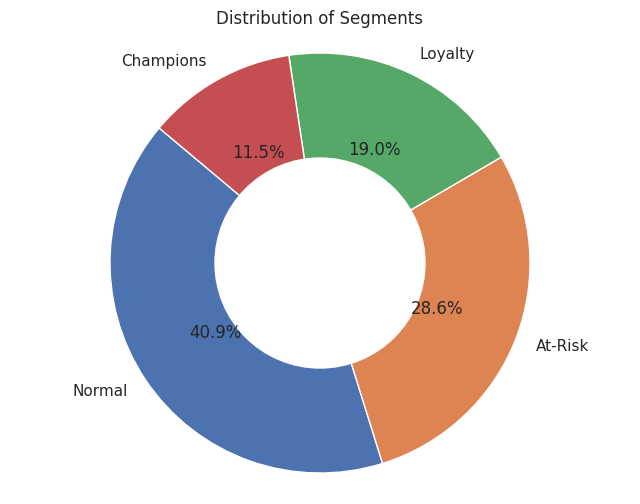

In [197]:
# Dữ liệu từ DataFrame
segments = ['Normal', 'At-Risk', 'Loyalty', 'Champions']
counts = [1770, 1237, 820, 498]

# Tạo biểu đồ tròn
plt.figure(figsize=(8, 6))

# Vẽ biểu đồ tròn chính
plt.pie(counts, labels=segments, autopct='%1.1f%%', startangle=140)

# Tạo và vẽ một hình tròn ở giữa
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribution of Segments')
plt.axis('equal')  # Đảm bảo biểu đồ là hình tròn
plt.show()

Champions: Những khách hàng có điểm số RFM cao nhất (4) cho cả Recency, Frequency và Monetary.

Loyalty: Những khách hàng có điểm số RFM từ 3 đến 4 cho cả Recency, Frequency và Monetary, nhưng không cao như Champions.

At-Risk: Những khách hàng có điểm số RFM từ 1 đến 2 cho cả Recency, Frequency và Monetary.

Normal: Những khách hàng còn lại, không rơi vào bất kỳ nhóm nào trên.

Dựa vào các tiêu chí đã cho, dưới đây là một số chiến lược để định nghĩa và xử lý các nhóm khách hàng:

Champions:

Chiến lược: Tập trung vào việc duy trì và phát triển mối quan hệ với nhóm khách hàng này bằng cách cung cấp các ưu đãi đặc biệt, ưu đãi VIP hoặc dịch vụ cao cấp.

Mục tiêu: Giữ chân khách hàng trong nhóm này, tạo điều kiện cho họ tiếp tục mua sắm và tăng chi tiêu.

Loyalty:

Chiến lược: Tiếp tục cung cấp ưu đãi và dịch vụ chăm sóc khách hàng tốt cho nhóm này, nhưng có thể không cần phải tập trung nhiều như trong nhóm Champions.

Mục tiêu: Duy trì sự hài lòng và trung thành của nhóm khách hàng này, khuyến khích họ mua sắm thường xuyên hơn và tăng giá trị đơn hàng.

At-Risk:

Chiến lược: Tập trung vào việc phát hiện và giải quyết các vấn đề hoặc không hài lòng của nhóm khách hàng này. Cung cấp các chương trình khuyến mãi và ưu đãi đặc biệt để giữ chân họ.

Mục tiêu: Chuyển đổi nhóm khách hàng này trở lại thành nhóm Loyalty hoặc Champions, tránh mất mát khách hàng.

Normal:

Chiến lược: Tiếp tục cung cấp sản phẩm và dịch vụ tốt, nhưng không cần tập trung nhiều như trong các nhóm khách hàng trên.

Mục tiêu: Xây dựng và duy trì mối quan hệ khách hàng ổn định, đảm bảo họ tiếp tục mua sắm với bạn mặc dù không nằm trong nhóm cao cấp.